In [1]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from keras import optimizers
from keras import callbacks
from keras.callbacks import ModelCheckpoint
import numpy as np
import glob as glob
from skimage import color
from skimage import io
from skimage import exposure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

Using TensorFlow backend.


In [8]:
# dimensions of our images.
img_width, img_height = 256, 256

train_data_dir = '../../data/model/key19_cropped/train'
validation_data_dir = '../../data/model/key19_cropped/val'
test_data_dir = '../data/model/key19/test'

nb_train_samples = int(len(glob.glob(train_data_dir+'/*/*.png')))
nb_validation_samples = int(len(glob.glob(validation_data_dir+'/*/*.png')))
epochs = 50
batch_size = 16

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

In [9]:
model = Sequential()

model.add(Conv2D(34, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(34, (5, 5)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(16, (8, 8)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(6))
model.add(Activation('softmax'))

AdamOpt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy',
              optimizer=AdamOpt,
              metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 254, 254, 34)      952       
_________________________________________________________________
activation_6 (Activation)    (None, 254, 254, 34)      0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 127, 127, 34)      0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 127, 127, 34)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 123, 123, 34)      28934     
_________________________________________________________________
activation_7 (Activation)    (None, 123, 123, 34)      0         
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 61, 61, 34)        0         
__________

In [10]:
def preprocess_img(img):
    img = img*1/255.0
    # Adaptive Equalization
    #img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.3)
    return img

In [11]:
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_img,
        width_shift_range=0.05,
        height_shift_range=0.05,
        zoom_range=0.05,
        fill_mode='constant')

validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_img)

In [12]:
train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical')

Found 200 images belonging to 6 classes.


In [13]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    shuffle = False,
    class_mode='categorical')

Found 84 images belonging to 6 classes.


In [14]:
checkpointer = ModelCheckpoint(filepath='../saved_weights/CNN_key19_weights_rgb.hdf5', verbose=0, save_best_only=True)

In [15]:
#model.load_weights('../saved_weights/CNN_key19_weights_updated.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=AdamOpt,
              metrics=['accuracy'])

In [16]:
model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size, verbose=1,
    callbacks=[checkpointer])

Epoch 1/50
13/12 [================================] - 14s 1s/step - loss: 1.8153 - acc: 0.2494 - val_loss: 1.8019 - val_acc: 0.0952
Epoch 2/50
13/12 [================================] - 11s 846ms/step - loss: 1.7145 - acc: 0.2732 - val_loss: 1.8097 - val_acc: 0.0833
Epoch 3/50
13/12 [================================] - 11s 850ms/step - loss: 1.6879 - acc: 0.2310 - val_loss: 1.8421 - val_acc: 0.0833
Epoch 4/50
13/12 [================================] - 11s 862ms/step - loss: 1.6814 - acc: 0.2963 - val_loss: 1.9289 - val_acc: 0.0833
Epoch 5/50
13/12 [================================] - 11s 852ms/step - loss: 1.6619 - acc: 0.2554 - val_loss: 1.8368 - val_acc: 0.2381
Epoch 6/50
13/12 [================================] - 11s 821ms/step - loss: 1.6003 - acc: 0.3213 - val_loss: 1.9208 - val_acc: 0.1071
Epoch 7/50
13/12 [================================] - 11s 837ms/step - loss: 1.5744 - acc: 0.3585 - val_loss: 1.9985 - val_acc: 0.1071
Epoch 8/50
13/12 [================================] - 11s 

In [11]:
loss, accuracy = model.evaluate_generator(validation_generator, 
                                steps = nb_validation_samples // batch_size)
print()
print('Test Loss:', loss)
print('Test Accuracy', accuracy)

c:\02456_deeplearning\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))



Test Loss: 0.122817895375
Test Accuracy 0.958333333333


In [12]:
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    color_mode =  "grayscale",
    shuffle = False,
    class_mode='categorical')

valid_pred_prob = model.predict_generator(validation_generator,steps = nb_validation_samples // batch_size, verbose=1)
valid_pred_labels = np.argmax(valid_pred_prob, axis=-1)

Found 192 images belonging to 6 classes.


c:\02456_deeplearning\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


12/12 [==============================] - 3s     


In [13]:
acc = 1-np.sum(valid_pred_labels!=validation_generator.classes[0:valid_pred_labels.shape[0]])/valid_pred_labels.shape[0]
acc

0.95833333333333337

In [119]:
#model.save('../saved_weights/CNN_key19_gray')

# Test data validation

In [16]:
model.load_weights('../saved_weights/CNN_key19_weights_updated.hdf5')
model.compile(loss='categorical_crossentropy',
              optimizer=AdamOpt,
              metrics=['accuracy'])

test_data_dir = '../data/model/key19/test'
nb_test_samples = int(len(glob.glob(test_data_dir+'/*/*.png')))


test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=1,
    shuffle = False,
    color_mode =  "grayscale",
    class_mode='categorical')

test_pred_prob = model.predict_generator(test_generator,steps = 153 // 1, verbose=1)
test_pred_labels = np.argmax(test_pred_prob, axis=-1)

Found 153 images belonging to 6 classes.
  9/153 [>.............................] - ETA: 2s

c:\02456_deeplearning\lib\site-packages\skimage\util\dtype.py:122: UserWarning: Possible precision loss when converting from float32 to uint16
  .format(dtypeobj_in, dtypeobj_out))


152/153 [============================>.] - ETA: 0s

In [17]:
acc = 1-np.sum(test_pred_labels!=test_generator.classes)/nb_test_samples
acc

0.73856209150326801

pos1\19_22_18_17_16_24_H_L_H_L_L_H_142_0_2315.png


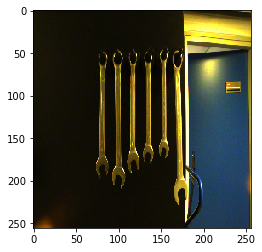

pos1\19_22_18_17_16_24_H_L_H_L_L_H_143_0_9061.png


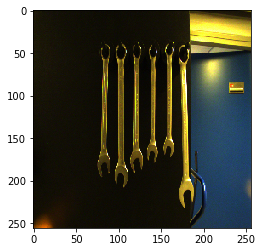

pos1\19_22_18_17_16_24_H_L_H_L_L_H_144_0_3577.png


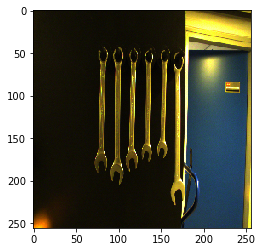

pos1\19_22_18_17_16_24_H_L_H_L_L_H_145_0_852.png


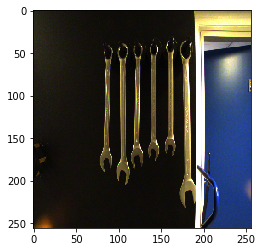

pos2\16_19_22_17_18_24_L_L_L_H_H_H_68_0_5614.png


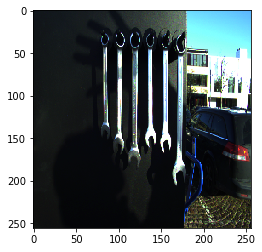

pos2\17_19_22_16_18_24_H_L_L_L_H_H_77_0_649.png


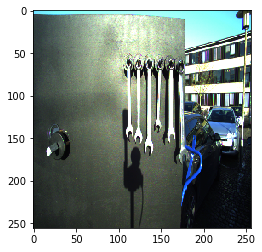

pos2\17_19_22_16_18_24_H_L_L_L_H_H_78_0_2134.png


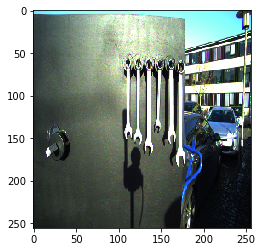

pos2\17_19_22_16_18_24_H_L_L_L_H_H_79_0_6038.png


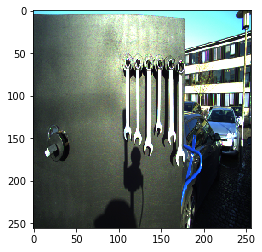

pos2\17_19_22_16_18_24_H_L_L_L_H_H_80_0_2465.png


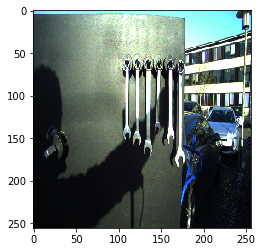

pos2\18_19_17_16_24_22_H_H_L_L_H_L_164_0_5275.png


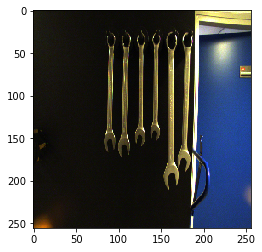

pos2\18_19_17_16_24_22_H_H_L_L_H_L_165_0_8672.png


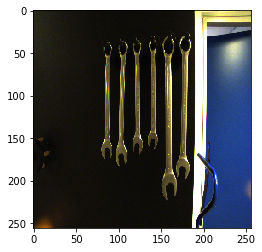

pos2\18_19_17_16_24_22_H_H_L_L_H_L_166_0_1274.png


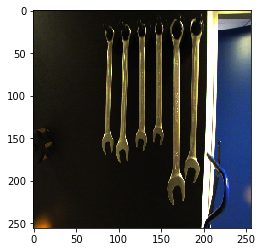

pos2\18_19_17_16_24_22_H_H_L_L_H_L_167_0_1935.png


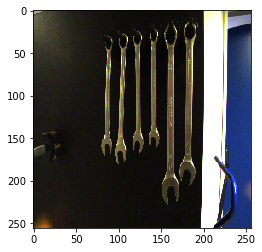

pos2\18_19_17_16_24_22_H_H_L_L_H_L_168_0_5315.png


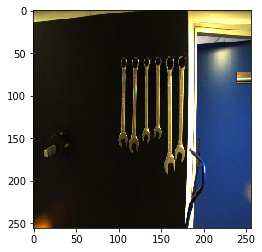

pos3\18_22_19_17_16_24_H_L_H_L_L_H_146_0_4825.png


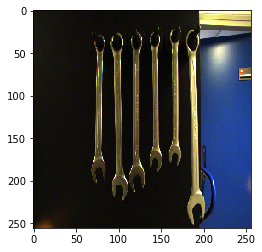

pos3\18_22_19_17_16_24_H_L_H_L_L_H_147_0_8322.png


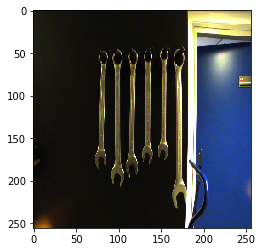

pos3\18_22_19_17_16_24_H_L_H_L_L_H_148_0_5255.png


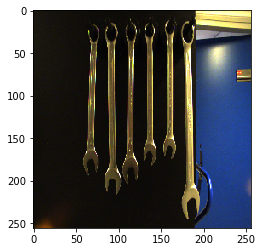

pos3\18_22_19_17_16_24_H_L_H_L_L_H_149_0_1013.png


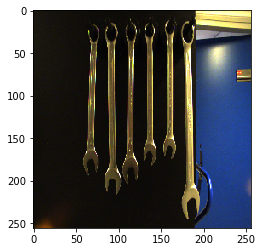

pos4\17_16_18_19_22_24_H_H_L_H_H_H_109_0_7086.png


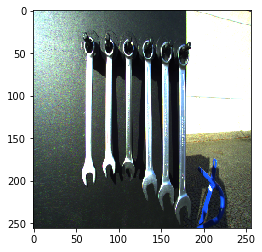

pos4\17_22_18_19_16_24_H_H_L_H_H_H_110_0_7817.png


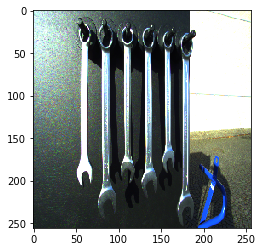

pos4\17_22_18_19_16_24_H_H_L_H_H_H_111_0_1469.png


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


pos4\18_22_17_19_16_24_L_H_H_H_H_H_124_0_8722.png


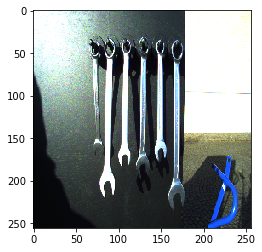

pos4\18_22_17_19_16_24_L_H_H_H_H_H_125_0_216.png


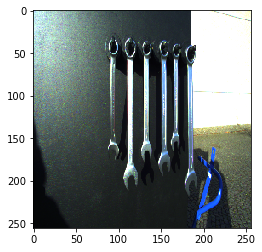

pos4\18_22_17_19_16_24_L_H_H_H_H_H_126_0_4199.png


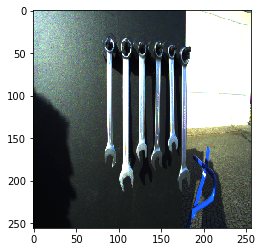

pos4\24_16_18_19_22_17_H_L_H_L_L_H_27_0_6094.png


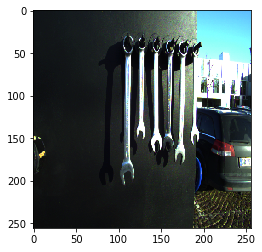

pos4\24_16_18_19_22_17_H_L_H_L_L_H_32_0_4865.png


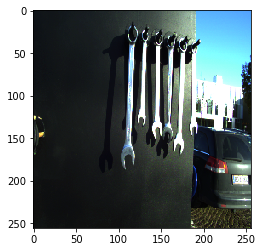

pos5\18_22_17_16_19_24_H_L_L_L_H_H_155_0_2756.png


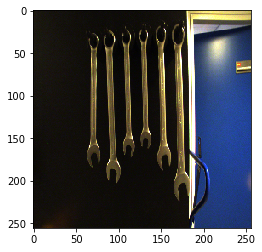

pos5\18_22_17_16_19_24_H_L_L_L_H_H_156_0_1639.png


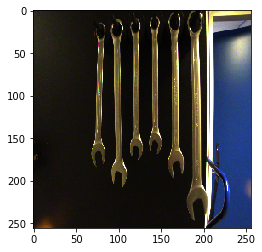

pos5\18_22_17_16_19_24_H_L_L_L_H_H_157_0_5619.png


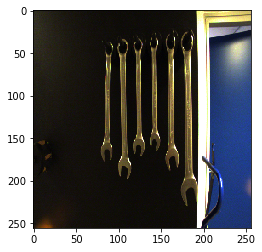

pos5\18_22_17_16_19_24_H_L_L_L_H_H_158_0_3549.png


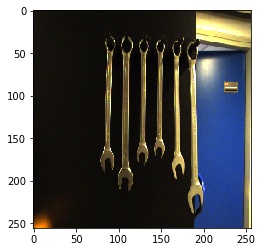

pos6\18_22_17_16_24_19_H_L_L_L_H_H_159_0_2902.png


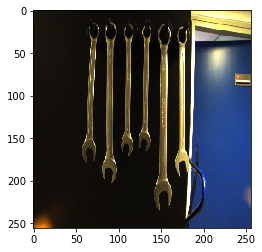

pos6\18_22_17_16_24_19_H_L_L_L_H_H_160_0_3350.png


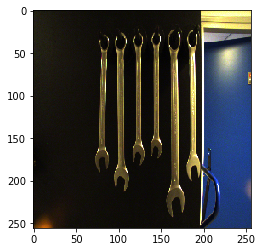

pos6\18_22_17_16_24_19_H_L_L_L_H_H_161_0_9580.png


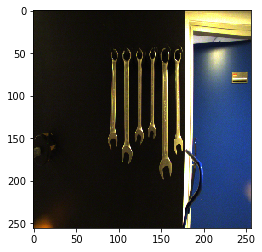

pos6\18_22_17_16_24_19_H_L_L_L_H_H_162_0_7354.png


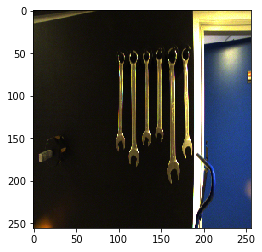

pos6\18_22_17_16_24_19_H_L_L_L_H_H_163_0_9984.png


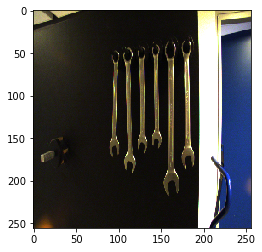

pos6\22_16_24_18_17_19_H_L_H_H_H_L_138_0_4833.png


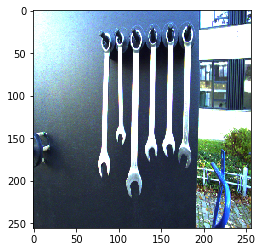

pos6\22_16_24_18_17_19_H_L_H_H_H_L_139_0_7087.png


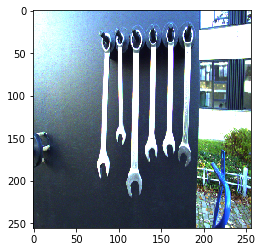

In [18]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
idx = np.array(np.where(test_pred_labels!=test_generator.classes))
for i in range(0,idx.shape[1]):
    print(test_generator.filenames[idx[0,i]])
    imgs=mpimg.imread(test_data_dir+'/'+test_generator.filenames[idx[0,i]])
    plt.figure()
    imgplot = plt.imshow(imgs)
    plt.show()

c:\02456_deeplearning\lib\site-packages\skimage\transform\_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


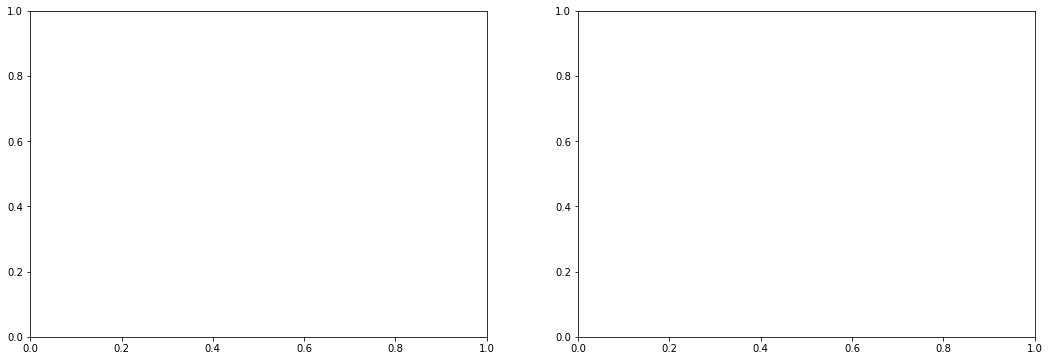

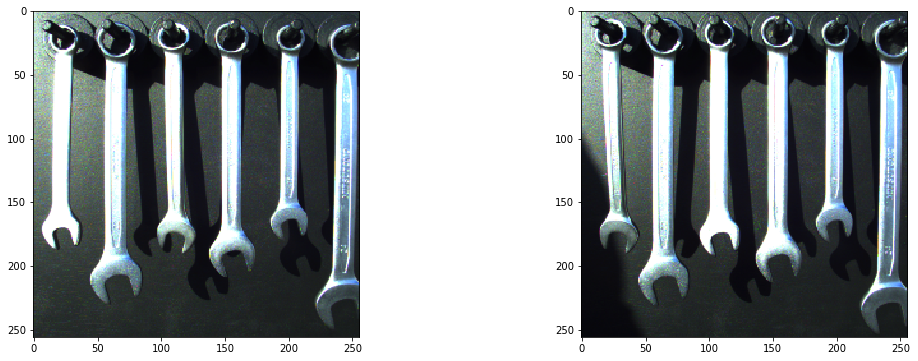

In [41]:
from vis.utils import utils
from keras import activations

layer_idx = -1
# Swap softmax with linear
model.layers[layer_idx].activation = activations.linear
model = utils.apply_modifications(model)

plt.rcParams['figure.figsize'] = (18, 6)

img1 = utils.load_img(train_data_dir+'/pos4/17_22_18_19_16_24_H_H_L_H_H_H_118.png', target_size=(256, 256))
img2 = utils.load_img(train_data_dir+'/pos4/18_22_17_19_16_24_L_H_H_H_H_H_119.png', target_size=(256, 256))


f, ax = plt.subplots(1, 2)
ax[0].imshow(img1)
ax[1].imshow(img2)
plt.show()

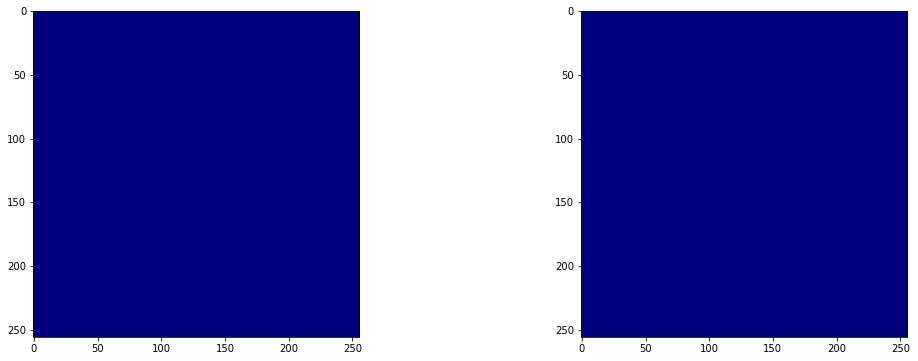

In [43]:
from vis.visualization import visualize_saliency, overlay
from vis.utils import utils
from keras import activations

# Utility to search for layer index by name. 
# Alternatively we can specify this as -1 since it corresponds to the last layer.

f, ax = plt.subplots(1, 2)
for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
    grads = visualize_saliency(model, layer_idx, filter_indices=3, seed_input=img)
    
    # visualize grads as heatmap
    ax[i].imshow(grads, cmap='jet')
plt.show()

In [44]:
for modifier in ['guided', 'relu']:
    plt.figure()
    f, ax = plt.subplots(1, 2)
    plt.suptitle(modifier)
    for i, img in enumerate([img1, img2]):    
        # 20 is the imagenet index corresponding to `ouzel`
        grads = visualize_saliency(model, layer_idx, filter_indices=[0], 
                                   seed_input=img, backprop_modifier=modifier)
        # Lets overlay the heatmap onto original image.    
        ax[i].imshow(grads, cmap='jet')
plt.show()

InternalError: Dst tensor is not initialized.
	 [[Node: _arg_Placeholder_88_0_5/_1433 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device_incarnation=1, tensor_name="edge_64__arg_Placeholder_88_0_5", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:GPU:0"]()]]
	 [[Node: Assign_88/_1453 = _Recv[_start_time=0, client_terminated=false, recv_device="/job:localhost/replica:0/task:0/device:CPU:0", send_device="/job:localhost/replica:0/task:0/device:GPU:0", send_device_incarnation=1, tensor_name="edge_97_Assign_88", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/device:CPU:0"]()]]

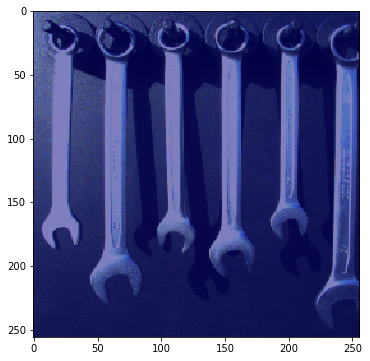

In [49]:
import numpy as np
import matplotlib.cm as cm
from vis.visualization import visualize_cam

#for modifier in [None, 'guided', 'relu']:
plt.figure()
#f, ax = plt.subplots(1, 2)
#plt.suptitle("vanilla" if modifier is None else modifier)
#for i, img in enumerate([img1, img2]):    
    # 20 is the imagenet index corresponding to `ouzel`
grads = visualize_cam(model, layer_idx, filter_indices=[5], 
                      seed_input=img1, backprop_modifier=None)        
    # Lets overlay the heatmap onto original image.    
    #jet_heatmap = np.uint8(cm.jet(grads)[..., :3] * 256)
#jet_heatmap = np.uint8(cm.jet(grads)[:,:,:,:3]*256)
plt.imshow(grads, cmap='jet')

plt.imshow(overlay(grads, img1))
plt.show()